* Author : Ruchit Vithani
* ID : 201701070
* Date : 09.14.2020
 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import copy
import time

# **• Implement a 5-layer Neural Network (3 Hidden Layers) as depicted in 2.1.**

In [2]:
"""
This class implements Layer in Neural network

    W : Weight matrix of this layer [m, n]
        where m = size of previous layer
              n = size of current layer
    
    b : biases of this layer [n,]

    activation : activation function applied at this layer. 

    This class provides all the layer functionalities. 
    These functionalities include : 

    (1) Affine forward : Linearly transforms input x according to equation np.dot(W.T, x) + b.
                         In other words, this is a linear function, calculaion of z (combines the 
                         weighted output from previous layer)

    (2) 


"""


# batch size
bs = 256
class Layer():
    def __init__(self, in_shape, out_shape, activation):
        self.W = tf.random.normal((in_shape, out_shape))
        self.b = tf.random.normal((out_shape,))
        self.activation = activation

    def affine_forward(self, x):
        """
            x : (N, D)
            W : (D, M)
            b : (M, )

            out : (N, M)
        """
        out = tf.matmul(x, self.W) + self.b

        self.cache = x

        return out

    def affine_backward(self, dz_l):
        x = self.cache
        """
            self.cache : 
                x : (N, D)

            dz_l : (N, M)

            dx : (N, D)
            dW : (D, M)
            db : (M, )
        """

        dW = (1./bs) * tf.matmul(x, dz_l, transpose_a=True)
        db = (1./bs) * tf.reduce_sum(dz_l, axis=0)
        da_l1 = tf.matmul(dz_l, self.W, transpose_b=True)

        return da_l1, dW, db

    def sigmoid_forward(self, z):
        out = tf.math.sigmoid(z)
        self.act_cache = z, out

        return out

    def sigmoid_backward(self):
        z, out = self.act_cache
        dz = out*(1-out)

        return dz

    def tanh_forward(self, z):
        out = tf.math.tanh(z)
        self.act_cache = z, out

        return out

    def tanh_backward(self):
        z, out = self.act_cache
        dz = 1 - out**2

        return dz

    def relu_forward(self, z):
        out = tf.maximum(z, 0)
        self.act_cache = z, out

        return out

    def relu_backward(self):
        z, out = self.act_cache
        dz = tf.cast(z>0, tf.float32)

        return dz

    def softmax_forward(self, z): 
        out = tf.math.softmax(z)
        self.act_cache = out

        return out

    def softmax_backward(self, y):
        out = self.act_cache
        return out - y

    def forward(self, x):
        if self.activation == "sigmoid":
            z = self.affine_forward(x)
            a = self.sigmoid_forward(z)
        elif self.activation == "tanh":
            z = self.affine_forward(x)
            a = self.tanh_forward(z)
        elif self.activation == "relu":
            z = self.affine_forward(x)
            a = self.relu_forward(z)
        else:
            z = x
            a = self.softmax_forward(z)

        return a

    def backward(self, dout):
        if self.activation == "softmax":
            dz_l = self.softmax_backward(dout)
            return dz_l
        elif self.activation == "sigmoid":
            dz_l = dout * self.sigmoid_backward()
        elif self.activation == "tanh":
            dz_l = dout * self.tanh_backward()
        elif self.activation == "relu":
            dz_l = dout * self.relu_backward()
        else:
            raise "Invalid activation provided"

        da_l1, dWl, dbl = self.affine_backward(dz_l)
        return da_l1, dWl, dbl

In [3]:
class NN():
    def __init__(self, s, a, lr):
        self.h1 = Layer(s[0], s[1], a[1])
        self.h2 = Layer(s[1], s[2], a[2])
        self.h3 = Layer(s[2], s[3], a[3])
        self.out = Layer(s[3], s[4], a[4])
        self.softmax = Layer(s[4], s[4], "softmax")

        self.lr = lr

    def forward(self, x):
        a1 = self.h1.forward(x)
        a2 = self.h2.forward(a1)
        a3 = self.h3.forward(a2)
        scores = self.out.forward(a3)
        probs = self.softmax.forward(scores)

        probs = tf.maximum(probs, 1e-6)
        return probs

    def backward(self, y):
        dout = self.softmax.backward(y)
        da3, dW4, db4 = self.out.backward(dout)
        da2, dW3, db3 = self.h3.backward(da3)
        da1, dW2, db2 = self.h2.backward(da2)
        dx, dW1, db1 = self.h1.backward(da1)

        self.out.W -= self.lr * dW4
        self.out.b -= self.lr * db4

        self.h3.W -= self.lr * dW3
        self.h3.b -= self.lr * db3

        self.h2.W -= self.lr * dW2
        self.h2.b -= self.lr * db2

        self.h1.W -= self.lr * dW1
        self.h1.b -= self.lr * db1

        return dx

In [4]:
def cross_entropy(y_hat, y):
     loss = tf.reduce_sum(-1.0 * y * tf.math.log(y_hat), axis=1)
     mean_loss = tf.reduce_mean(loss)
     return mean_loss

def cal_accuracy(predictions, y):
    accuracy = tf.reduce_mean(tf.cast(predictions==y, dtype=tf.float32))
    return accuracy

def predict(model, X):
    predictions = tf.argmax(model.forward(X), axis=1)
    return predictions

In [5]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

y = tf.one_hot(train_labels, 10)
train_images = train_images.reshape(60000, 784)
test_images = test_images.reshape(10000, 784)

# **• Trying different activations : Activation functions for hidden layers and output layers can be chosen as per your choice.**
Play around with Sigmoid , Softmax , RELU and TanH functions. Comment on the observations

In [6]:
batch_size = bs
activations = [None] + ["sigmoid"]*4
shapes = [784, 512, 256, 128, 10]
lr = 1e-1
model = NN(shapes, activations, lr)
model_copy = copy.deepcopy(model)

num_epochs = 50
sigmoid_itr_losses = []
sigmoid_epoch_losses = []
for epoch in tqdm(range(num_epochs)):
    st=0
    tot_loss = 0
    tot_iterations = 60000//batch_size
    for st in range(tot_iterations):
        y1 = y[st*batch_size : (st+1)*batch_size]
        inp = train_images[st*batch_size : (st+1)*batch_size]
        y_hat = model.forward(inp)
        loss =  cross_entropy(y_hat, y1)
        tot_loss += loss
        model.backward(y1)
        sigmoid_itr_losses.append(loss)
    sigmoid_epoch_losses.append(tot_loss)

100%|██████████| 50/50 [04:50<00:00,  5.81s/it]


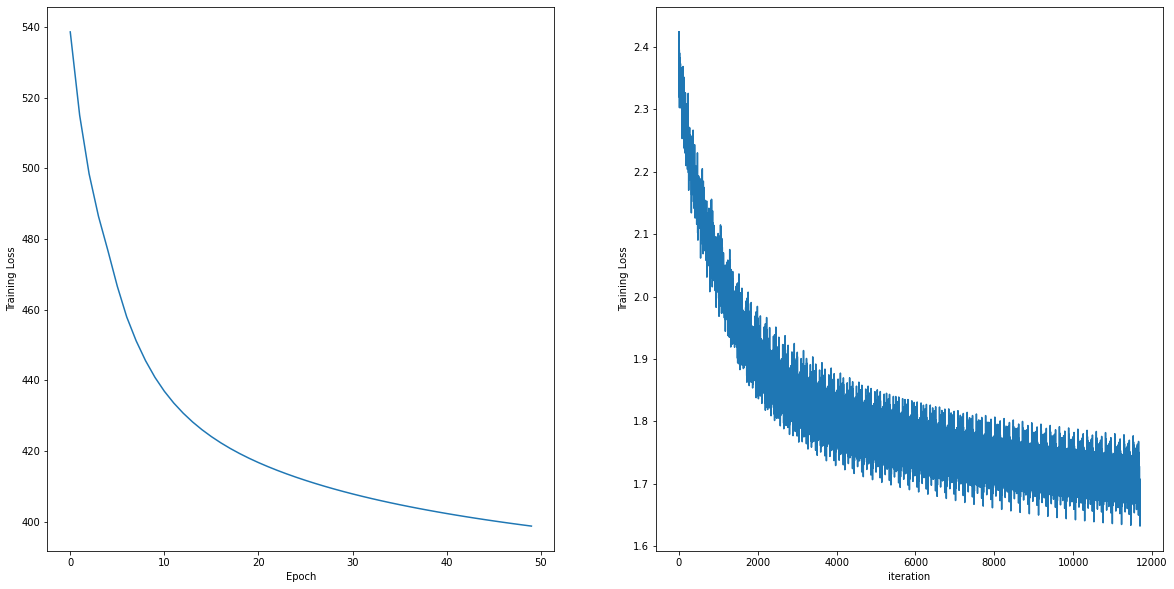

In [7]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(sigmoid_epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.subplot(1, 2, 2)
plt.plot(sigmoid_itr_losses)
plt.xlabel("iteration")
plt.ylabel("Training Loss")
plt.show()

In [8]:
batch_size = bs
activations = [None] + ["tanh"]*4
shapes = [784, 512, 256, 128, 10]
lr = 1e-1
model = NN(shapes, activations, lr)

num_epochs = 50
tanh_itr_losses = []
tanh_epoch_losses = []
for epoch in tqdm(range(num_epochs)):
    st=0
    tot_loss = 0
    tot_iterations = 60000//batch_size
    for st in range(tot_iterations):
        y1 = y[st*batch_size : (st+1)*batch_size]
        inp = train_images[st*batch_size : (st+1)*batch_size]

        y_hat = model.forward(inp)
        loss =  cross_entropy(y_hat, y1)
        tot_loss += loss
        model.backward(y1)
        tanh_itr_losses.append(loss)
    tanh_epoch_losses.append(tot_loss)

100%|██████████| 50/50 [05:37<00:00,  6.75s/it]


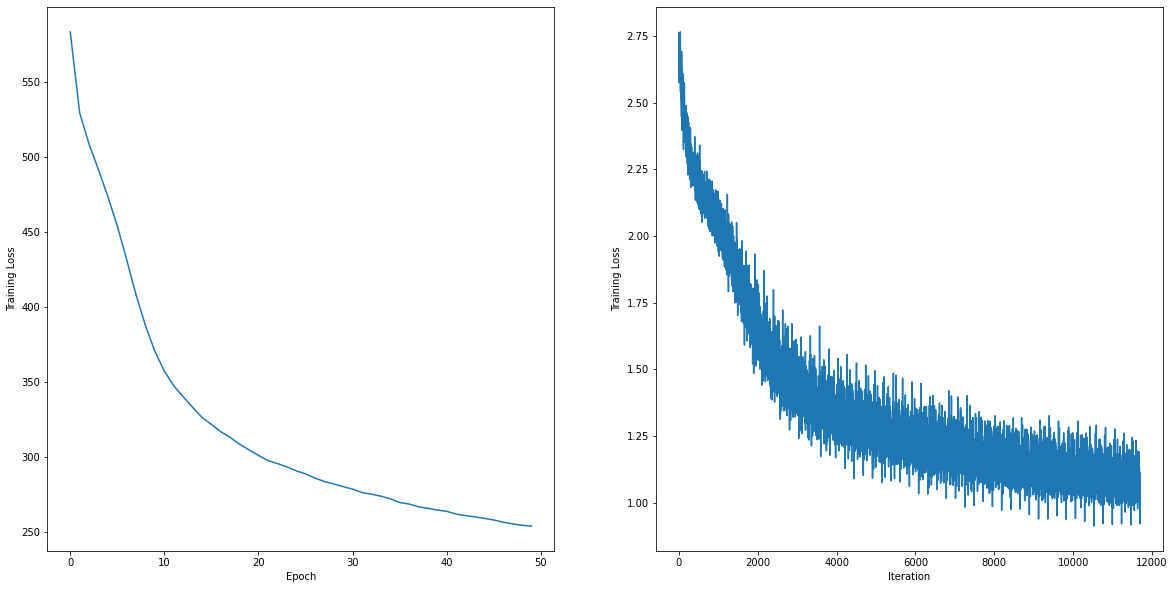

In [9]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(tanh_epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.subplot(1, 2, 2)
plt.plot(tanh_itr_losses)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.show()

In [10]:
batch_size = bs
activations = [None] + ["relu", "tanh", "relu", "tanh"]
shapes = [784, 512, 256, 128, 10]
lr = 1e-1
model = NN(shapes, activations, lr)

num_epochs = 50
relu_itr_losses = []
relu_epoch_losses = []
for epoch in tqdm(range(num_epochs)):
    st=0
    tot_loss = 0
    tot_iterations = 60000//batch_size
    for st in range(tot_iterations):
        y1 = y[st*batch_size : (st+1)*batch_size]
        inp = train_images[st*batch_size : (st+1)*batch_size]

        y_hat = model.forward(inp)
        loss =  cross_entropy(y_hat, y1)
        tot_loss += loss
        model.backward(y1)
        relu_itr_losses.append(loss)
    relu_epoch_losses.append(tot_loss)

100%|██████████| 50/50 [05:10<00:00,  6.21s/it]


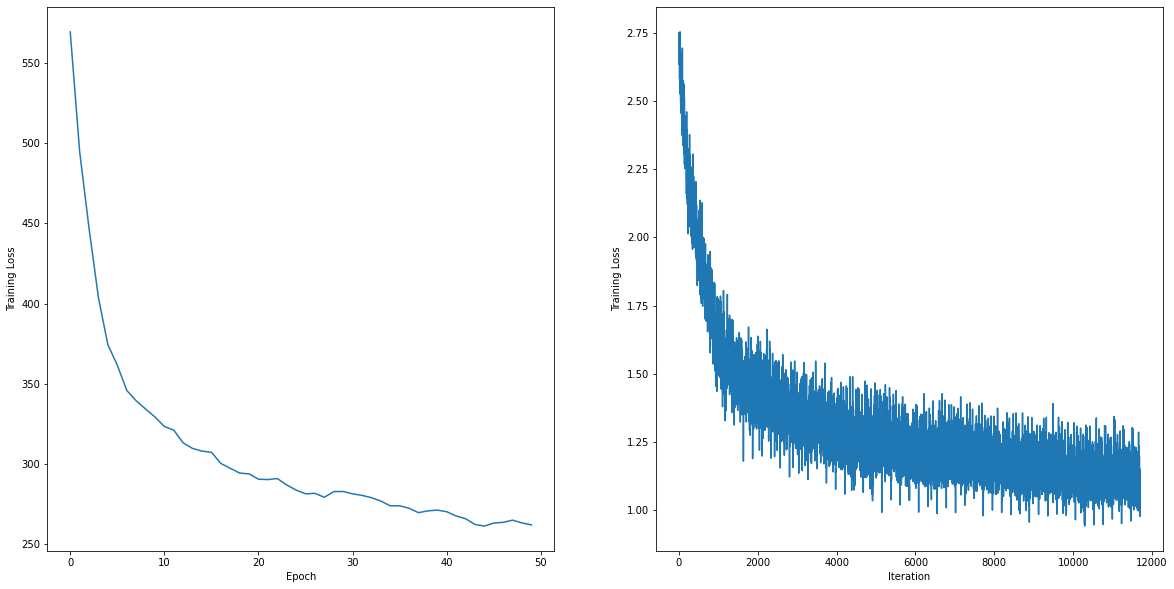

In [11]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(relu_epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.subplot(1, 2, 2)
plt.plot(relu_itr_losses)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.show()

# **Comparison of different activation functions**

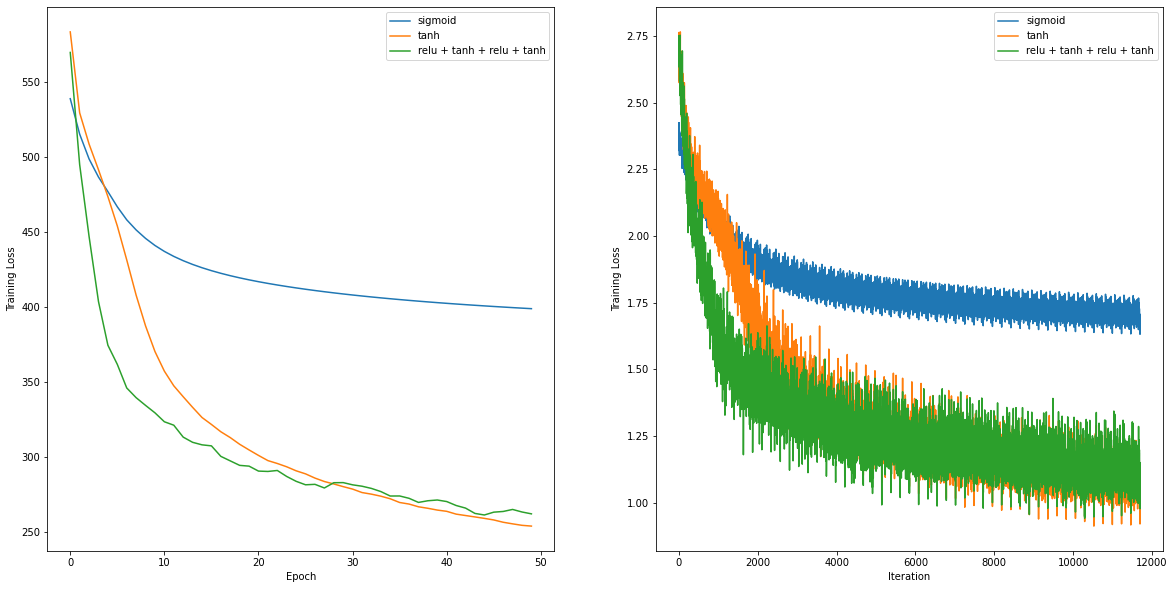

In [12]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(sigmoid_epoch_losses)
plt.plot(tanh_epoch_losses)
plt.plot(relu_epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend(["sigmoid", "tanh", "relu + tanh + relu + tanh"])
plt.subplot(1, 2, 2)
plt.plot(sigmoid_itr_losses)
plt.plot(tanh_itr_losses)
plt.plot(relu_itr_losses)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.legend(["sigmoid", "tanh", "relu + tanh + relu + tanh"])
plt.show()

#### **Observations**

* Neural net with tanh activation trains faster than neural net with sigmoid activations.
* Adding intermediate ReLU layers in tanh neural network improves training time, so ReLU neural network converges faster than tanh neural network.

#### **Reasoning and justification**
(1) **sigmoid activation** 
* Maximum derivative of sigmoid function is 0.25. In deeper neural networks, at most 0.25 times the gradient from previous layer is able to flow backward to next layer. So, weights in the first layer have gradients at most : $(0.25)^4 = 0.0039$. So, it is hard to train deeper neural net when all the activations are sigmoid. The main reason behind this is due to smaller and smaller gradients flowing backwards, and hence, making smaller and smaller updates in the weights. In other words, weights in the initial layers do not change much, and so, the neural network train very slowly. 

(2) **tanh activation**
* tanh has similar curve as that of sigmoid, but, the range of tanh is $[-1, 1]$, instead of $[0, 1]$ of sigmoid. In addition to this, maximum derivative of tanh is $1$, which is also more than that of sigmoid. This implies that when using tanh activation function, backwards flow of gradients is more compared to sigmoid. The problem of diminishing gradients is less in tanh compared to sigmoid. **So, tanh is better than sigmoid activation function.**

(3) **ReLU activation**
* For most of the range on real line, sigmoid is saturated either to 0 or to 1. Similarly, tanh is saturated to value -1 or 1 for most of the range on real line. This saturated values have gradients very close to 0. In other words, most of the times, gradients of tanh and sigmoid are closer to zero. This leads to smaller or no updates in the weights making it difficult for the neural net to train. This problem is solved by ReLU activation. The gradients in ReLU are not saturated like those in sigmoid or tanh. **Hence, ReLU network trains faster than sigmoid network or tanh network.** 

# **• Use different Batch Sizes and analyse how the accuracy is changing.**

In [17]:
batch_sizes = [128, 256, 512, 1024, 2048, 60000]

acc = []
for batch_size in batch_sizes:
    print("\nBatch size = ", batch_size)
    t1 = time.time()
    bs = batch_size
    activations = [None] + ["tanh"]*4
    shapes = [784, 512, 256, 128, 10]
    lr = 1e-1
    model = NN(shapes, activations, lr)

    num_epochs = 20
    accuracy = []
    for epoch in range(num_epochs):
        st=0
        tot_loss = 0
        tot_iterations = 60000//batch_size
        for st in range(tot_iterations):
            y1 = y[st*batch_size : (st+1)*batch_size]
            inp = train_images[st*batch_size : (st+1)*batch_size]

            y_hat = model.forward(inp)
            loss =  cross_entropy(y_hat, y1)
            tot_loss += loss
            model.backward(y1)

        test_set_predictions = predict(model, test_images)
        test_set_accuracy = cal_accuracy(test_set_predictions, test_labels)
        accuracy.append(test_set_accuracy)    

        print("Epoch : {}\tTest set Accuracy = {}".format(epoch+1, test_set_accuracy))
    acc.append(accuracy)


Batch size =  128
Epoch : 1	Test set Accuracy = 0.26910001039505005
Epoch : 2	Test set Accuracy = 0.39649999141693115
Epoch : 3	Test set Accuracy = 0.510200023651123
Epoch : 4	Test set Accuracy = 0.578000009059906
Epoch : 5	Test set Accuracy = 0.6287999749183655
Epoch : 6	Test set Accuracy = 0.6575999855995178
Epoch : 7	Test set Accuracy = 0.6909999847412109
Epoch : 8	Test set Accuracy = 0.7045000195503235
Epoch : 9	Test set Accuracy = 0.7245000004768372
Epoch : 10	Test set Accuracy = 0.7401999831199646
Epoch : 11	Test set Accuracy = 0.7573999762535095
Epoch : 12	Test set Accuracy = 0.7634000182151794
Epoch : 13	Test set Accuracy = 0.7723000049591064
Epoch : 14	Test set Accuracy = 0.7784000039100647
Epoch : 15	Test set Accuracy = 0.7886000275611877
Epoch : 16	Test set Accuracy = 0.7950999736785889
Epoch : 17	Test set Accuracy = 0.7990999817848206
Epoch : 18	Test set Accuracy = 0.8037999868392944
Epoch : 19	Test set Accuracy = 0.8101999759674072
Epoch : 20	Test set Accuracy = 0.8169999

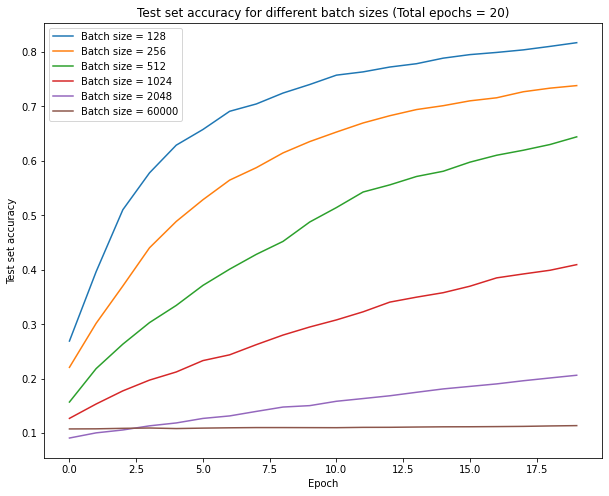

In [18]:
legend = ["Batch size = {}".format(size) for size in batch_sizes]
plt.figure(figsize=(10, 8))
for p in acc:
    plt.plot(p)
plt.xlabel("Epoch")
plt.ylabel("Test set accuracy")
plt.title("Test set accuracy for different batch sizes (Total epochs = 20)")
plt.legend(legend)
plt.show()

In terms of training time : as we can see from above cell, smaller the batch size, less the time per iteration required for execution. For larger batch size, training accuracy saturation is slower. So, for same number of epochs, smaller batch gets more accuracy, and the reason is smaller number of examples in that batch (again note that I have run the same batch for same number of iterations to compare the batch sizes). In simple terms, when using smaller batch size, model takes many number of steps trying to fit all those small batches, while in case of large batch size, model takes comparatively less number of steps(considering same number of training epochs), and so, less number of updates. In any single update, fitting smaller batch is easier compared to fitting larger batch size. 

**That is why, accuracy for using smaller batch size is better**

# **• Also play around with different sizes of Hidden Layers and see the difference you get. Comment on it.**

In [19]:
shapes = [
    [784, 16, 16, 16, 10],
    [784, 64, 64, 64, 10],
    [784, 128, 128, 128, 10],
    [784, 256, 256, 256, 10],
    [784, 512, 512, 512, 10],
    [784, 256, 64, 16, 10],
    [784, 256, 128, 64, 10],
    [784, 1024, 512, 512, 10]
]

activations = [None] + ["tanh"]*4
lr = 1e-1
bs = 64
batch_size = bs

accuracies = []
for shape in shapes:
    print("Layer sizes = ", shape)
    model = NN(shape, activations, lr)

    tanh_itr_losses = []
    tanh_epoch_losses = []
    acc1 = []
    for epoch in range(num_epochs):
        st=0
        tot_loss = 0
        tot_iterations = 60000//batch_size
        for st in range(tot_iterations):
            y1 = y[st*batch_size : (st+1)*batch_size]
            inp = train_images[st*batch_size : (st+1)*batch_size]

            y_hat = model.forward(inp)
            loss =  cross_entropy(y_hat, y1)
            tot_loss += loss
            model.backward(y1)
            tanh_itr_losses.append(loss)
        tanh_epoch_losses.append(tot_loss)

        predictions = predict(model, test_images)
        accuracy = cal_accuracy(predictions, test_labels)

        print("Epoch : {}\tTest_set_accuracy : {}".format(epoch+1, accuracy))
        acc1.append(accuracy)
    accuracies.append(acc1)
    print("\n\n")

Layer sizes =  [784, 16, 16, 16, 10]
Epoch : 1	Test_set_accuracy : 0.32179999351501465
Epoch : 2	Test_set_accuracy : 0.4851999878883362
Epoch : 3	Test_set_accuracy : 0.5342000126838684
Epoch : 4	Test_set_accuracy : 0.5784000158309937
Epoch : 5	Test_set_accuracy : 0.6208999752998352
Epoch : 6	Test_set_accuracy : 0.6514000296592712
Epoch : 7	Test_set_accuracy : 0.6718000173568726
Epoch : 8	Test_set_accuracy : 0.6947000026702881
Epoch : 9	Test_set_accuracy : 0.7107999920845032
Epoch : 10	Test_set_accuracy : 0.7172999978065491
Epoch : 11	Test_set_accuracy : 0.7253000140190125
Epoch : 12	Test_set_accuracy : 0.7336000204086304
Epoch : 13	Test_set_accuracy : 0.7419999837875366
Epoch : 14	Test_set_accuracy : 0.7533000111579895
Epoch : 15	Test_set_accuracy : 0.76419997215271
Epoch : 16	Test_set_accuracy : 0.7720999717712402
Epoch : 17	Test_set_accuracy : 0.7838000059127808
Epoch : 18	Test_set_accuracy : 0.7914999723434448
Epoch : 19	Test_set_accuracy : 0.8101999759674072
Epoch : 20	Test_set_acc

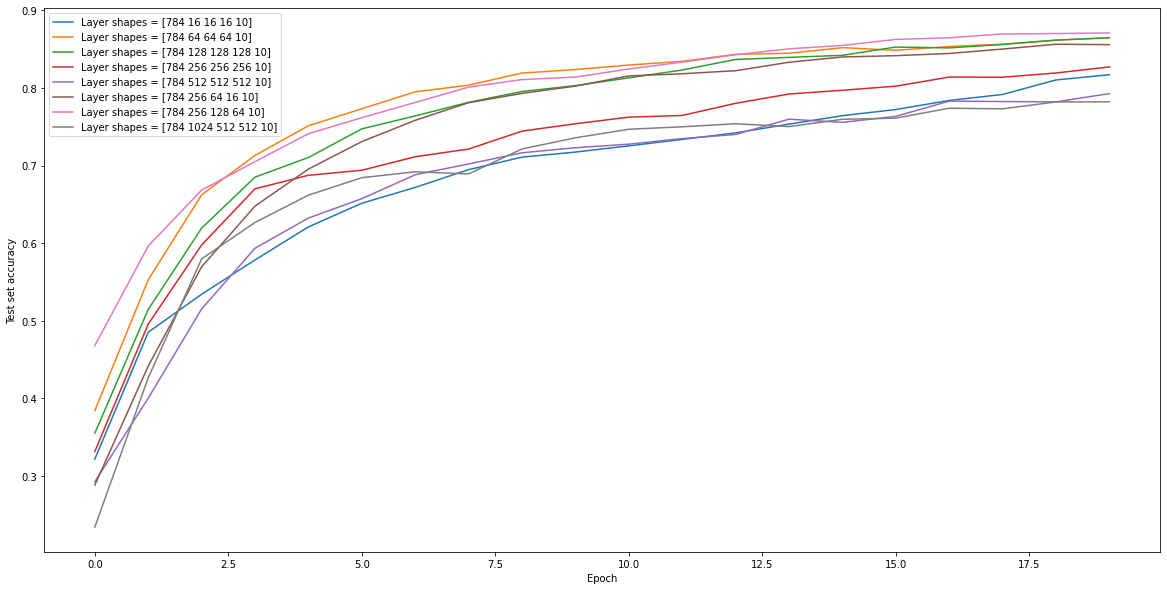

In [20]:
legend = ["Layer shapes = [" + ' '.join(str(e) for e in ls) + "]" for ls in shapes]
plt.figure(figsize=(20, 10))
for acy in accuracies:
    plt.plot(acy)
plt.xlabel("Epoch")
plt.ylabel("Test set accuracy")
plt.legend(legend)
plt.show()

As we can see from above curves, small models with shapes of hidden layer = [16, 16, 16] produces good test set accuracy. Bigger model has more number of weights and more

# **• Design a Confusion Matrix depicting the outputs you got**

From all of the experiments done above, we select the model which is giving the best performance, and train that model for large number of epochs in order to gain good test set accuracy. 

In [36]:
def test_performance(model, inp, y, labels):
    y_hat = model.forward(inp)
    loss = cross_entropy(y_hat, y)
    predictions = tf.argmax(y_hat, axis=1)
    accuracy = cal_accuracy(predictions, labels)

    return loss, accuracy, predictions
    

In [37]:
batch_size = bs
activations = [None] + ["tanh"]*4
shapes = [784, 256, 128, 64, 10]
lr = 1e-1
model = NN(shapes, activations, lr)

num_epochs = 200

tanh_itr_losses = []
tanh_epoch_losses = []
accuracies = []
test_losses = []
y_test = tf.one_hot(test_labels, 10)
for epoch in range(num_epochs):
    st=0
    tot_loss = 0
    tot_iterations = 60000//batch_size
    for st in range(tot_iterations):
        y1 = y[st*batch_size : (st+1)*batch_size]
        inp = train_images[st*batch_size : (st+1)*batch_size]

        y_hat = model.forward(inp)
        loss =  cross_entropy(y_hat, y1)
        tot_loss += loss
        model.backward(y1)
        tanh_itr_losses.append(loss)
    tot_loss/= tot_iterations
    loss, accuracy, predictions = test_performance(model, test_images, y_test, test_labels)

    test_losses.append(loss)
    tanh_epoch_losses.append(tot_loss)
    accuracies.append(accuracy)
    print("Epoch : {}\tTraining loss : {}\t\tTest loss : {}\t\tTest_set_accuracy : {}".format(epoch+1, tot_loss, loss, accuracy))

Epoch : 1	Training loss : 2.205925703048706		Test loss : 1.9313390254974365		Test_set_accuracy : 0.37059998512268066
Epoch : 2	Training loss : 1.75521719455719		Test loss : 1.603287696838379		Test_set_accuracy : 0.5386999845504761
Epoch : 3	Training loss : 1.525193691253662		Test loss : 1.4588377475738525		Test_set_accuracy : 0.6169000267982483
Epoch : 4	Training loss : 1.4071173667907715		Test loss : 1.357904076576233		Test_set_accuracy : 0.6723999977111816
Epoch : 5	Training loss : 1.336761236190796		Test loss : 1.3115628957748413		Test_set_accuracy : 0.7117999792098999
Epoch : 6	Training loss : 1.2910853624343872		Test loss : 1.2672373056411743		Test_set_accuracy : 0.7360000014305115
Epoch : 7	Training loss : 1.2541438341140747		Test loss : 1.227868914604187		Test_set_accuracy : 0.7552000284194946
Epoch : 8	Training loss : 1.221285343170166		Test loss : 1.2029389142990112		Test_set_accuracy : 0.7688000202178955
Epoch : 9	Training loss : 1.1956751346588135		Test loss : 1.180018901824

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
confusion = confusion_matrix(predictions, test_labels)
print(confusion)
print("\n")
print(classification_report(predictions, test_labels))

[[ 948    0   14    6    0   13   17    4    8    6]
 [   0 1108    2    0    0    3    4   11    6    6]
 [   1    5  935   17    7    1   11   26    7    4]
 [   3    6   19  908    2   43    3    2   26   10]
 [   0    0   11    1  894    8   17   16   12   41]
 [  10    1    2   34    2  769   14    0   20   10]
 [  12    0   10    3   13   15  884    1    7    4]
 [   3    3   11   12    2    6    1  937    9   16]
 [   3   12   26   22    6   24    7    1  872    9]
 [   0    0    2    7   56   10    0   30    7  903]]


              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1016
           1       0.98      0.97      0.97      1140
           2       0.91      0.92      0.91      1014
           3       0.90      0.89      0.89      1022
           4       0.91      0.89      0.90      1000
           5       0.86      0.89      0.88       862
           6       0.92      0.93      0.93       949
           7       0.91      0.94 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


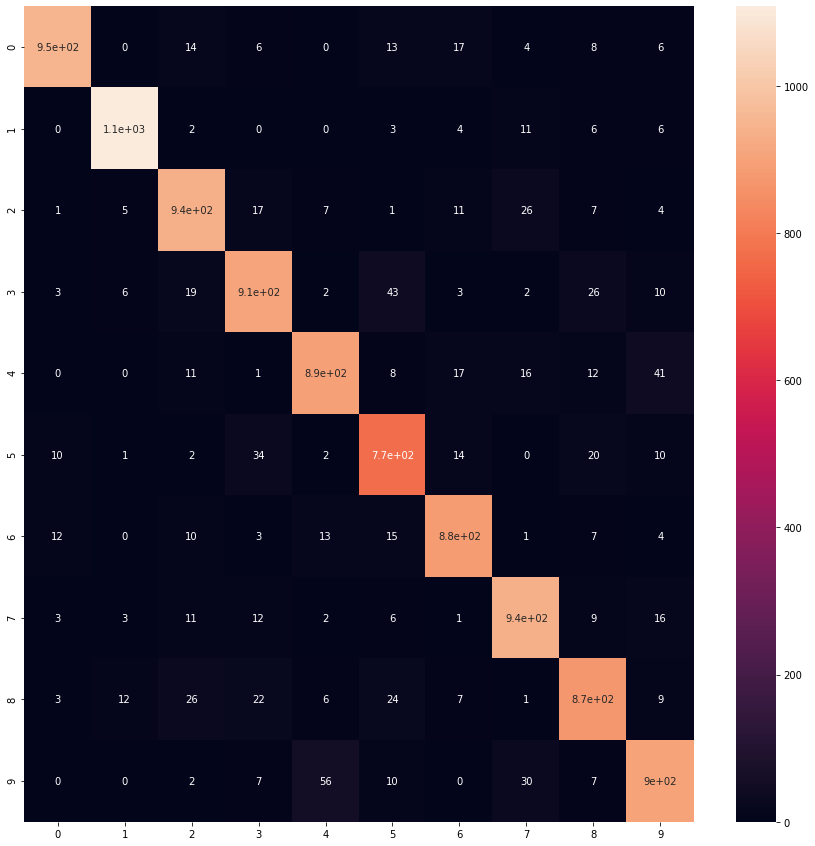

In [39]:
import seaborn

fig, ax = plt.subplots(figsize=(15,15))
seaborn.heatmap(confusion, ax=ax, annot=True)
plt.show()

# **Visualize Weight Matrices and see the change as the epochs increase. (during training)**

In [61]:
batch_size = bs
activations = [None] + ["tanh"]*4
shapes = [784, 64, 64, 64, 10]
lr = 1e-1
model = NN(shapes, activations, lr)

num_epochs = 50
tanh_itr_losses = []
tanh_epoch_losses = []
for epoch in range(num_epochs):
    st=0
    tot_loss = 0
    tot_iterations = 60000//batch_size
    for st in range(tot_iterations):
        y1 = y[st*batch_size : (st+1)*batch_size]
        inp = train_images[st*batch_size : (st+1)*batch_size]

        y_hat = model.forward(inp)
        loss =  cross_entropy(y_hat, y1)
        tot_loss += loss
        model.backward(y1)
        tanh_itr_losses.append(loss)
    tanh_epoch_losses.append(tot_loss)
    predictions = predict(model, test_images)
    accuracy = cal_accuracy(predictions, test_labels)
    print("Epoch : {}\tTest_set_accuracy : {}".format(epoch+1, accuracy))

    model.forward(train_images[0].reshape(1, 784))
    if (epoch + 1)%3 == 0:
        l1 = tf.reshape(model.h1.cache, (28, 28))
        l2 = tf.reshape(model.h2.cache, (8, 8))
        l3 = tf.reshape(model.h3.cache, (8, 8))
        l4 = tf.reshape(model.out.cache, (8, 8))

        print("\n\nVisualising all layer outputs")
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 4, 1)
        plt.imshow(l1, cmap="gray")
        plt.subplot(1, 4, 2)
        plt.imshow(l2, cmap="gray")
        plt.subplot(1, 4, 3)
        plt.imshow(l3, cmap="gray")
        plt.subplot(1, 4, 4)
        plt.imshow(l4, cmap="gray") 
        plt.show()
        
        print("\n\nVisualising all weight matrices")
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 4, 1)
        plt.imshow(model.h1.W, cmap="gray")
        plt.subplot(1, 4, 2)
        plt.imshow(model.h2.W, cmap="gray")
        plt.subplot(1, 4, 3)
        plt.imshow(model.h3.W, cmap="gray")
        plt.subplot(1, 4, 4)
        plt.imshow(model.out.W, cmap="gray")
        plt.show()

        print("\n\nVisualising biases of all layers")
        b1 = tf.reshape(model.h1.b, (8,8))
        b2 = tf.reshape(model.h2.b, (8,8))
        b3 = tf.reshape(model.h3.b, (8,8))
        b4 = tf.reshape(tf.repeat(model.out.b, 10), (10, 10))

        plt.figure(figsize=(10, 8))
        plt.subplot(1, 4, 1)
        plt.imshow(b1, cmap="gray")
        plt.subplot(1, 4, 2)
        plt.imshow(b2, cmap="gray")
        plt.subplot(1, 4, 3)
        plt.imshow(b3, cmap="gray")
        plt.subplot(1, 4, 4)
        plt.imshow(b4, cmap="gray")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

On visualising layer outputs, we might guess that these layers are trying to learn different edges in the image. For example, when the input is 5, the layer outputs have family of edges in the direction y = x. 

# **CIFAR test images**

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
data2 = np.array(x_train)
data2 = (data2 - np.mean(data2,axis=(0,1,2)))/np.std(data2,axis=(0,1,2))
data2 = data2.reshape([50000,3072])
data2 = tf.convert_to_tensor(data2,dtype=tf.dtypes.float32)
train = data2

170500096/170498071 [==============================] - 2s 0us/step


In [6]:
testData2 = np.array(x_test)
testData2 = (testData2 - np.mean(testData2,axis=(0,1,2)))/np.std(testData2,axis = (0,1,2))
testData2 = testData2.reshape([10000,3072])
testData2 = tf.convert_to_tensor(testData2,dtype=tf.dtypes.float32)
y_train2 = tf.reshape(tf.one_hot(y_train, 10), (50000, 10))
y_test2 = tf.reshape(tf.one_hot(y_test, 10), (10000, 10))
test = testData2

In [8]:
train_images = train
y = y_train2
test_images = test
test_labels = tf.cast(tf.reshape(y_test, (10000, )), tf.float32)

batch_size = bs
activations = [None] + ["tanh"]*4
shapes = [3072, 1024, 512, 128, 10]
lr = 1e-1
model = NN(shapes, activations, lr)

num_epochs = 100
tanh_itr_losses = []
tanh_epoch_losses = []
for epoch in range(num_epochs):
    st=0
    tot_loss = 0
    tot_iterations = 60000//batch_size
    for st in range(tot_iterations):
        y1 = y[st*batch_size : (st+1)*batch_size]
        inp = train_images[st*batch_size : (st+1)*batch_size]

        y_hat = model.forward(inp)
        loss =  cross_entropy(y_hat, y1)
        tot_loss += loss
        model.backward(y1)
        tanh_itr_losses.append(loss)
    tanh_epoch_losses.append(tot_loss)

    predictions = predict(model, test_images)
    predictions = tf.cast(predictions, tf.float32)
    accuracy = cal_accuracy(predictions, test_labels)
    print("Epoch : {}\tTest_set_accuracy : {}".format(epoch+1, accuracy))

Epoch : 1	Test_set_accuracy : 0.11649999767541885
Epoch : 2	Test_set_accuracy : 0.1340000033378601
Epoch : 3	Test_set_accuracy : 0.14380000531673431
Epoch : 4	Test_set_accuracy : 0.1525000035762787
Epoch : 5	Test_set_accuracy : 0.15729999542236328
Epoch : 6	Test_set_accuracy : 0.15700000524520874
Epoch : 7	Test_set_accuracy : 0.16110000014305115
Epoch : 8	Test_set_accuracy : 0.1606999933719635
Epoch : 9	Test_set_accuracy : 0.16590000689029694
Epoch : 10	Test_set_accuracy : 0.16099999845027924
Epoch : 11	Test_set_accuracy : 0.1656000018119812
Epoch : 12	Test_set_accuracy : 0.1687999963760376
Epoch : 13	Test_set_accuracy : 0.1670999974012375
Epoch : 14	Test_set_accuracy : 0.1615999937057495
Epoch : 15	Test_set_accuracy : 0.17350000143051147
Epoch : 16	Test_set_accuracy : 0.16850000619888306
Epoch : 17	Test_set_accuracy : 0.1746000051498413
Epoch : 18	Test_set_accuracy : 0.1720999926328659
Epoch : 19	Test_set_accuracy : 0.16990000009536743
Epoch : 20	Test_set_accuracy : 0.1705999970436096

# **Printing confusion matrix for CIFAR dataset**

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
confusion = confusion_matrix(predictions, test_labels)
print(confusion)
print("\n")
print(classification_report(predictions, test_labels))

[[695 251 234 170 129 233  58 169 652 253]
 [119 512 217 263 224 197 345 212 189 467]
 [ 61  80 373 315 480 329 388 321  36  46]
 [ 21  39  67 125  63 119  94  63  21  17]
 [  7  21  23  31  29  32  29  50  10  20]
 [  9   8  11  13  11  27   8  14   8   7]
 [  7  11   9  17   7   5  24  23   3  16]
 [ 26  13  34  25  28  26  28  86  10  40]
 [ 21  25  11  17  14  16   6  13  43  39]
 [ 34  40  21  24  15  16  20  49  28  95]]


              precision    recall  f1-score   support

         0.0       0.69      0.24      0.36      2844
         1.0       0.51      0.19      0.27      2745
         2.0       0.37      0.15      0.22      2429
         3.0       0.12      0.20      0.15       629
         4.0       0.03      0.12      0.05       252
         5.0       0.03      0.23      0.05       116
         6.0       0.02      0.20      0.04       122
         7.0       0.09      0.27      0.13       316
         8.0       0.04      0.21      0.07       205
         9.0       0.10   

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


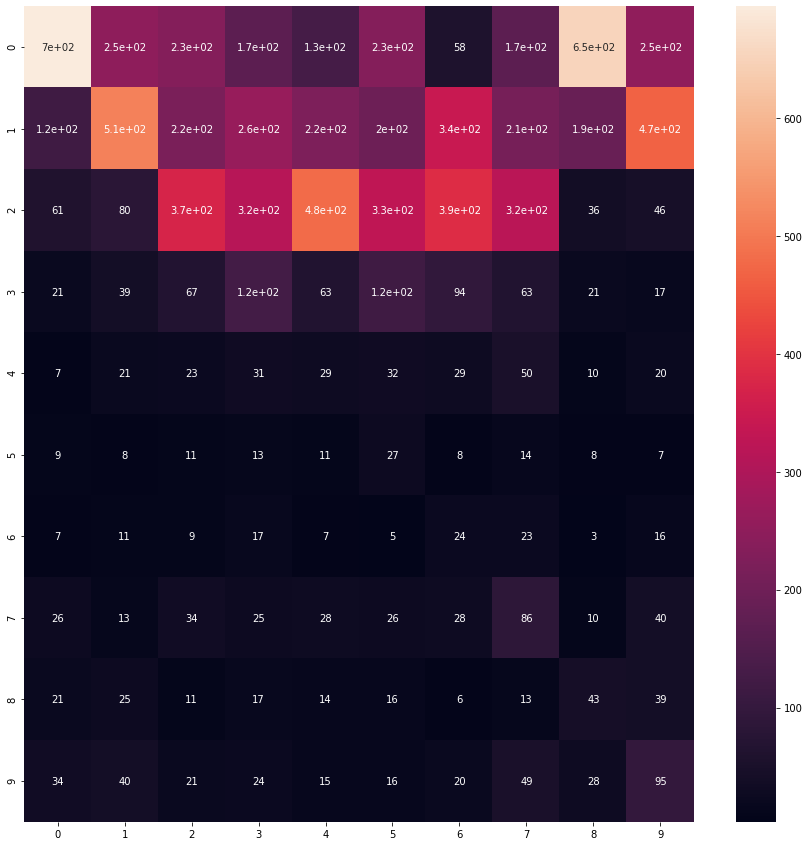

In [17]:
import seaborn

fig, ax = plt.subplots(figsize=(15,15))
seaborn.heatmap(confusion, ax=ax, annot=True)
plt.show()

## **Observation**

In case of MNIST digits : No of input features are less compared to CIFAR images. Also, we completely ignore the spatial information when we flatten the input images. So, with the same architecture, we get lesser accuracy for CIFAR images. To gain more accuracy, we need to build even larger and more complex network. Also using the spatial information and color information can improve accuracy. We did not do any of that in this case. So, we get lesser accuracy for CIFAR 10 dataset. 

So, even after training for 100 epochs, we are not able to get accuracy more than 25%. To fit the model on CIFAR dataset, we need to think of more complex model and also incorporate the color and spatial information, which we did not in this case. 